Epoch 1 Average loss: 284.3668
Epoch 2 Average loss: 255.1176
Epoch 3 Average loss: 249.6518
Epoch 4 Average loss: 247.1684
Epoch 5 Average loss: 245.6833
Epoch 6 Average loss: 244.6959
Epoch 7 Average loss: 243.9391
Epoch 8 Average loss: 243.3886
Epoch 9 Average loss: 242.9429
Epoch 10 Average loss: 242.5152


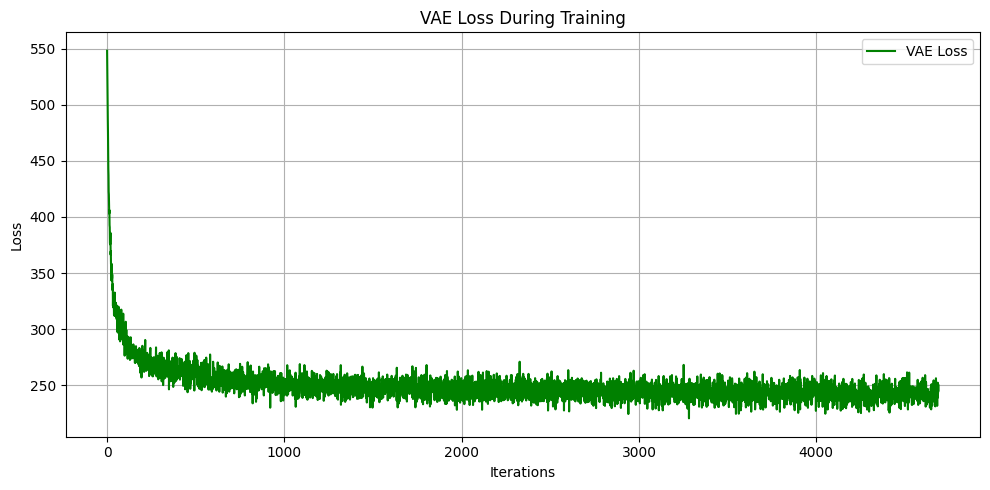

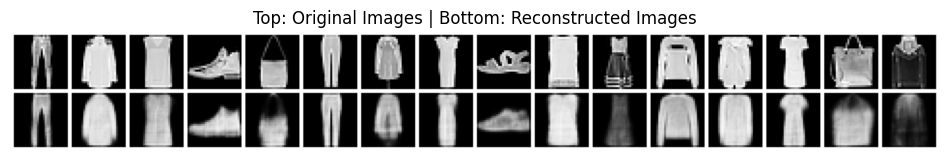

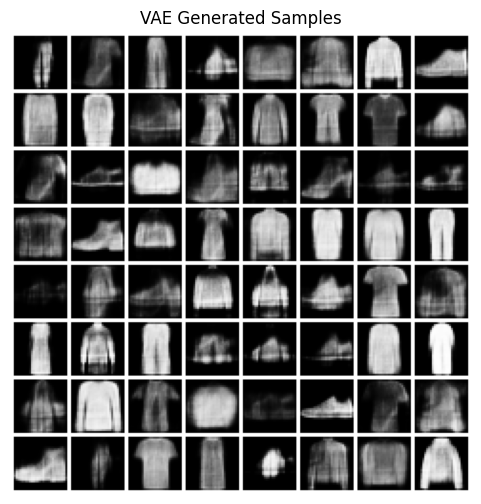

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# VAE model definition
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 400)
        self.fc21 = nn.Linear(400, 20)  # mu
        self.fc22 = nn.Linear(400, 20)  # logvar
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 28 * 28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function (restored to original scaling style)
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (BCE + KLD) / x.size(0)  # normalize by batch size

# Data loading
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Model, optimizer
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
latent_dim = 20
vae_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        vae_losses.append(loss.item())  # Track loss per batch

    print(f"Epoch {epoch} Average loss: {train_loss / len(train_loader):.4f}")

# Plot VAE loss like GAN
plt.figure(figsize=(10,5))
plt.plot(vae_losses, label='VAE Loss', color='green')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('VAE Loss During Training')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("vae_loss_plot.png")
plt.show()

# Task 3: Compare input and reconstructed images
model.eval()
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to(device)
    recon_images, _, _ = model(test_images)
    recon_images = recon_images.view(-1, 1, 28, 28).cpu()

comparison = torch.cat([test_images.cpu(), recon_images])
grid = make_grid(comparison, nrow=16, pad_value=1)
plt.figure(figsize=(12, 4))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.title("Top: Original Images | Bottom: Reconstructed Images")
plt.savefig("vae_recon_comparison.png")
plt.show()

# Generate and visualize samples (GAN-style grid)
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    generated = model.decode(z).view(-1, 1, 28, 28).cpu()

grid = make_grid(generated, nrow=8, normalize=True, pad_value=1)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.title(f"VAE Generated Samples")
plt.savefig("vae_epoch_output.png")
plt.show()
